In [6]:
# Date: 06-10-2021
# Author: Joshua Soutelo Vieira

### Histograms in computer vision

Why are histograms so useful? They capture the frequency distribution of pixel intensity values.

In [98]:
import os
import json

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [99]:
def grab_fields():
    toret = {}
    
    for field in fields:
        name = field['field']
        x = field['coord_pixel'][0]
        y = field['coord_pixel'][1]
        w = field['width']
        h = field['height']
    
        form_field = form[y:y+h, x:x+w]
        toret[name] = form_field
    
    return toret

def grab_fields_coords(file):
    with open(file, "r") as f:
        content = json.loads(f.read())

    return content 

def show_image(image, name=None, true_size=False):
    if true_size:
        show_image_true_size(image, name=name)
    else:
        plt.title(name)
        plt.xlabel(str(image.shape[1]) + " px")
        plt.ylabel(str(image.shape[0]) + " px")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
    
    
def show_image_true_size(image, name=None):
    dpi = 80
    height, width = image.shape[:2]
    figsize = width / float(dpi), height / float(dpi)
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(name)
    plt.show()
    
def bw(image, threshold=None, show=False):
    # First transform the image to gray scale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Sometimes we choose to set the threshold manually assuming that the Otsu algorithm wasn't unable to find a proper one
    if threshold:
        (thresh, bw_img) = cv2.threshold(gray_img, threshold, 255, cv2.THRESH_BINARY_INV)
    else:
        # Treshold set to -0 to point out that it's Otsu's algorithm job to decide it
        (thresh, bw_img) = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    if show:
        show_image(gray_img, "Gray scale")
        show_image(bw_img, "Trehshold (B&W)")
    
    return bw_img

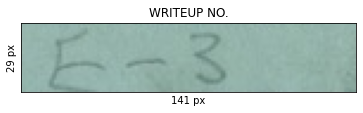

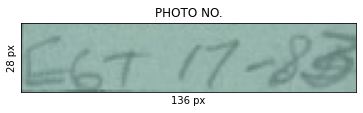

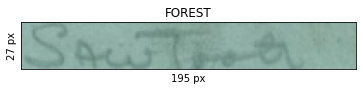

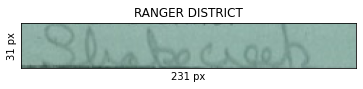

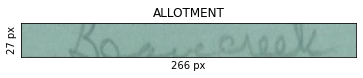

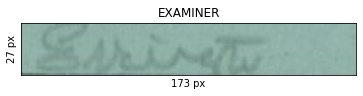

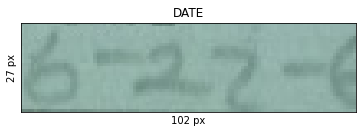

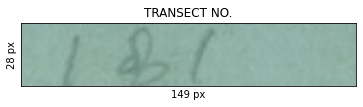

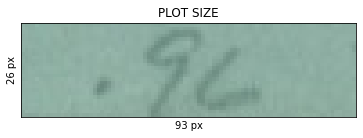

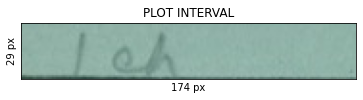

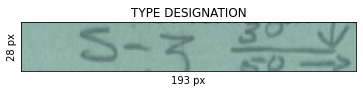

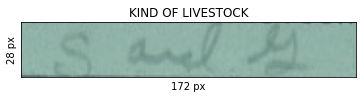

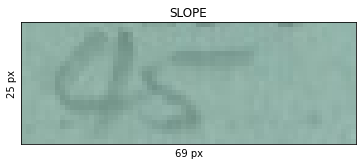

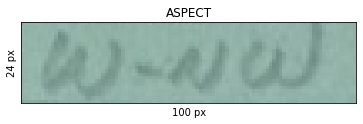

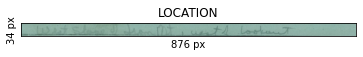

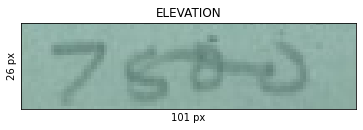

In [100]:
fields = grab_fields_coords("all_fields.json")['fields']
form = cv2.imread("highRes_ForestService.jpg")
fields = grab_fields()
field = fields[list(fields)[len(list(fields))-2]]
for field_name, crop_img in fields.items():
    show_image(crop_img, name=field_name)

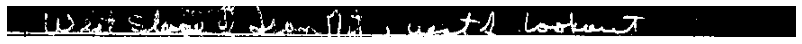

In [103]:
bw_image = bw(field)
show_image_true_size(bw_image)

In [102]:
# https://developpaper.com/python-implementation-of-image-vertical-projection-example/
# https://arxiv.org/pdf/2103.08922v1.pdf
# http://www.cvc.uab.es/icdar2009/papers/3725a651.pdf
# file:///home/jsv/Downloads/amc27114.pdf

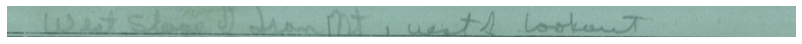

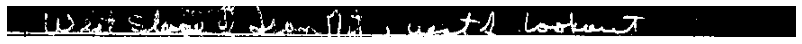

In [104]:
show_image_true_size(field)
show_image_true_size(bw_image)

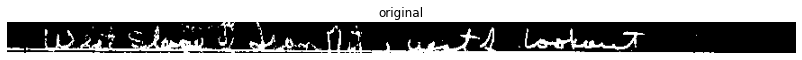

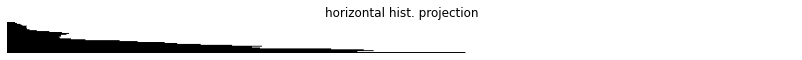

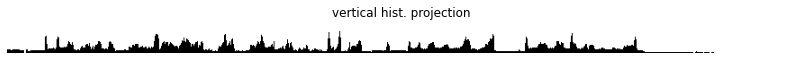

In [105]:
def create_h_v_projections(image, show=False):
    h_projection = image.copy()
    v_projection = image.copy()
    
    # Vertical projection
    (h, w) = h_projection.shape
    a = [0 for _ in range(w)]

    for x in range(w):
        for y in range(h):
            if v_projection[y, x] == 255:
                a[x] += 1
                v_projection[y, x] = 0

    for x in range(w):
        for y in range(h - a[x]):
            v_projection[y, x] = 255

    # Horizontal projection
    (h, w) = h_projection.shape
    b = [0 for _ in range(h)]

    for y in range(h):
        for x in range(w):
            if h_projection[y, x] == 255:
                b[y] += 1
                h_projection[y, x] = 0

    for y in range(h):
        for x in range(b[y], w):
            h_projection[y, x] = 255

    if show:
        show_image(image, name="original", true_size=True)
        show_image(h_projection, name="horizontal hist. projection", true_size=True)
        show_image(v_projection, name="vertical hist. projection", true_size=True)
    
    return h_projection, v_projection

h_proj, v_proj = create_h_v_projections(bw_image, show=True)

- #### What happens if we perform a gaussian blurring before the thresholding?

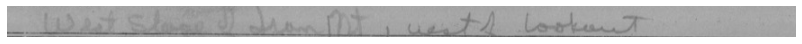

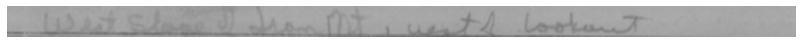

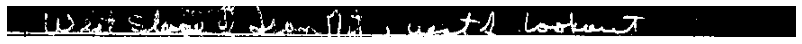

In [106]:
gray_img = cv2.cvtColor(field, cv2.COLOR_BGR2GRAY)
show_image(gray_img, true_size=True)
gauss_img = cv2.GaussianBlur(gray_img, (3,3), 2)
show_image(gauss_img, true_size=True)
(thresh, thresh_img) = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
show_image(thresh_img, true_size=True)
h_proj, v_proj = create_h_v_projections(thresh_img)
# We can see that it remains practically the same...

- #### What if we first remove long horizontal and vertical lines? (form lines appearing in the image as a result of the cropping)

Algorithm II.1 from this paper [https://arxiv.org/pdf/2103.08922v1.pdf]

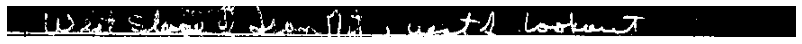

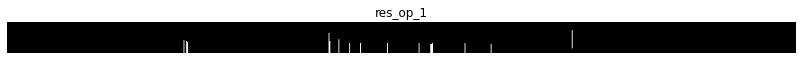

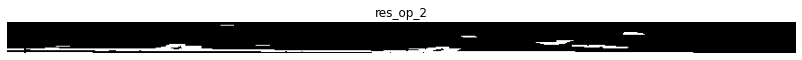

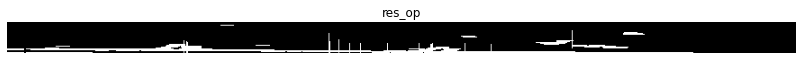

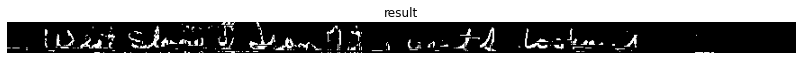

In [129]:
# Start with the thresholded image
#field = fields['PLOT INTERVAL']
field = fields['LOCATION']
bw_img = bw(field)
show_image(bw_img, true_size=True)
"""
 [INFO] 
  https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html
 
 [TERMS]
  opening operation => erosion followed by dilation
  erosion => we can think of it as noise removal
  dilation => we can think of it as make the foreground more prominent
  
 Steps:
  1. black image | opening | structuring element E (w=1, h=param1) -> res_op_1
  2. black image | opening | structuring element E (w=param1, h=1) -> res_op_2
  3. res_op_1 + res_op_2 -> res_op
  4. black_image - res_op -> result
"""
# Step 1
param_1 = 4
kernel = np.ones((5,5),np.uint8)
res_op_1 = cv2.morphologyEx(bw_img, cv2.MORPH_OPEN, np.ones((20, 1), np.uint8))
show_image(res_op_1, "res_op_1", true_size=True)
# Step 2
res_op_2 = cv2.morphologyEx(bw_img, cv2.MORPH_OPEN, np.ones((1, 15), np.uint8))
show_image(res_op_2, "res_op_2", true_size=True)
# Step 3
res_op = res_op_1 + res_op_2
show_image(res_op, "res_op", true_size=True)
# Step 4
line_1_result = bw_img - res_op
show_image(line_1_result, "result", true_size=True)

def remove_long_h_v_lines(bw_img, show=False):
    param_1 = 4
    kernel = np.ones((5,5),np.uint8)
    res_op_1 = cv2.morphologyEx(bw_img, cv2.MORPH_OPEN, np.ones((20, 1), np.uint8))
    # Step 2
    res_op_2 = cv2.morphologyEx(bw_img, cv2.MORPH_OPEN, np.ones((1, 15), np.uint8))
    # Step 3
    res_op = res_op_1 + res_op_2
    # Step 4
    line_1_result = bw_img - res_op
    if show: 
        show_image(line_1_result, "horizontal and vertical lines cleaned")
    
    return line_1_result

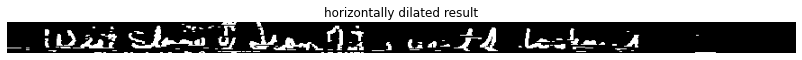

In [132]:
# Now perform horizontal dilation on the result
kernel = np.ones((1, 2), np.uint8)
h_dil_res = cv2.dilate(line_1_result, kernel,iterations=2)
show_image(h_dil_res, "horizontally dilated result", true_size=True)

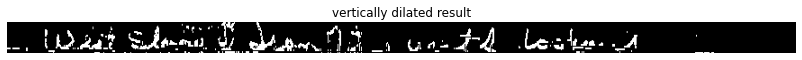

In [109]:
# Perform vertical dilation on the result
kernel = np.ones((2, 1), np.uint8)
v_dil_res = cv2.dilate(line_1_result, kernel,iterations=1)
show_image(v_dil_res, "vertically dilated result", true_size=True)

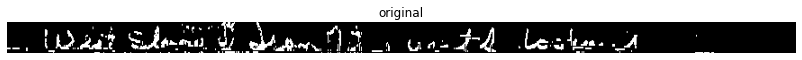

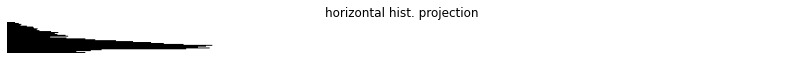

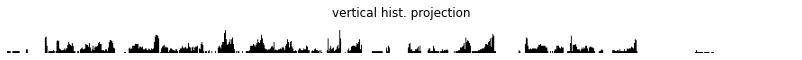

In [110]:
# Lets see the image projections
h_proj, v_proj = create_h_v_projections(v_dil_res, show=True)

**Conclusion:** We can see that the horizontal histogram projection now presents more gaps in it. 

Would that help determine a sliding window horizontal length based on that information? Let's continue with the steps in the algorithm II.1 [https://arxiv.org/pdf/2103.08922v1.pdf%5D]

We've previously performed the second line of the algorithm, which objective was removing long horizontal and vertical lines. Now we're going to implement third line of the same algorithm to try to concatenate pieces of characters horizontally.

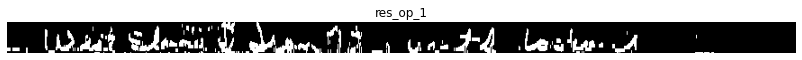

In [111]:
 """
 Steps:
  1. line_1_result | dilation | structuring element E (w=param2, 1) -> res_op_1
  2. res_op_1 | inverse -> line_2_result
"""
res_op_1 = cv2.dilate(line_1_result, (5, 1), iterations=3)
show_image(res_op_1, name="res_op_1", true_size=True)

In [112]:
h_proj, v_proj = create_h_v_projections(res_op_1)

Still don't know how to merge this with information with the sliding window... Try a different approach

The sliding window has two parameters that can be tweaked. The window size and the step.

- How could we better adjust the window size by looking at the horizontal histogram projection?
- How could we better adjust the step parameter by looking at the same information?

[file:///home/jsv/Downloads/TSP_CMC_28373.pdf]

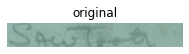

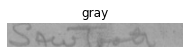

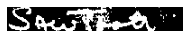

(195,)

In [113]:
# Vertical projection - Section 4.1
field = fields['FOREST']
show_image(field, name="original", true_size=True)
gray_img = cv2.cvtColor(field, cv2.COLOR_BGR2GRAY)
show_image(gray_img, name="gray", true_size=True)
(thresh, thresh_img) = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
show_image(thresh_img, true_size=True)

vertical_projection_hist = np.sum(thresh_img / 255, axis=0)
vertical_projection_hist.shape

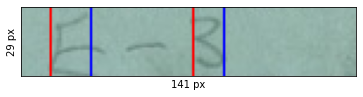

In [118]:
# Segmentate field into words - Section 4.2
def seg_field_words(v_proj_hist):
    words = []
    start = None
    end = None
    recording = False
    px_freq_thresh = 2
    for idx, freq in enumerate(v_proj_hist):

        if not recording:
            if freq > px_freq_thresh:
                recording = True
                start = idx
            else:
                continue
        else:
            if freq > px_freq_thresh:
                continue
            else:
                end = idx - 1
                recording = False
                if (end - start) >= 5:
                    words.append((start, end))
            
    return words


words = seg_field_words(vertical_projection_hist)
segmented = field.copy()     
for word in words:
    start, end = word
    segmented = cv2.line(segmented, (start, 0), (start, field.shape[0]), (0, 0, 255), 1)
    segmented = cv2.line(segmented, (end, 0), (end, field.shape[0]), (255, 0, 0), 1)
show_image(segmented)

In [120]:
# Segmentation points extraction algorithm - Section 4.3
def segmentation_points(v_projection, block_size, step_size, thresh):
    seg = []
    sumC = 0 # Sum of current block values
    sumP = 0 # Sum of preceding block values
    i = step_size
    j = 0
    k = 0
    
    while k <= block_size:
        sumP += v_projection[k]
        k += 1
    
    while i < (v_projection.shape[0] - block_size):
        
        k = i
        while k <= (i + block_size):
            sumC += v_projection[k]
            k += 1
        
        if (sumP - sumC) > thresh:
            seg.insert(j, i + (block_size / 2)) # Keep the index of the segmentation
            j += 1
            sumP = 0
        else:
            sumP = sumC
            
        i += step_size
        sumC = 0
    
    return seg
    
# seg_points = segmentation_points(vertical_projection_hist, 9, 5, 3)

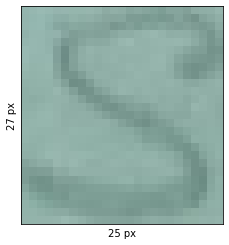

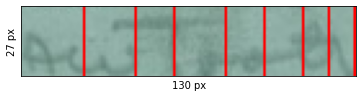

In [116]:
for word in words:
    start, end = word
    word_v_hist_proj = vertical_projection_hist[start:end + 1]
    word_seg_p = segmentation_points(word_v_hist_proj, 6, 5, 55)
    
    segmented = field.copy()[:, start:end+1]
    if word_seg_p:
        for seg_p in seg_points:
            segmented = cv2.line(segmented, (int(seg_p), 0), (int(seg_p), field.shape[0]), (0, 0, 255), 1)
    show_image(segmented)

Field name: WRITEUP NO.


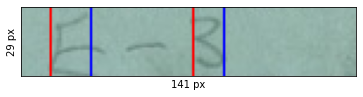

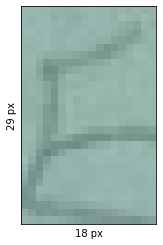

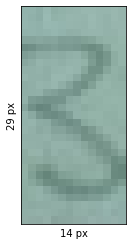

Field name: PHOTO NO.


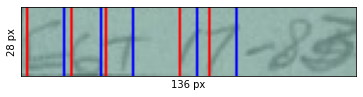

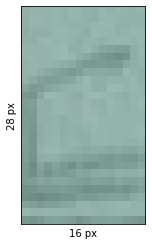

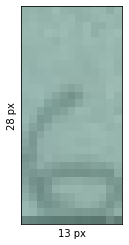

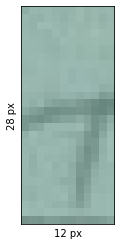

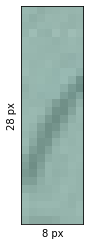

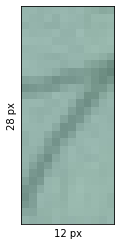

Field name: FOREST


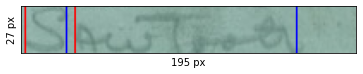

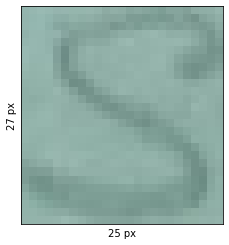

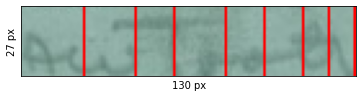

Field name: RANGER DISTRICT


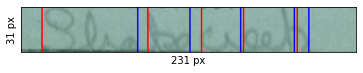

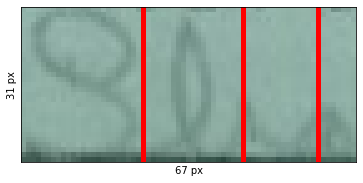

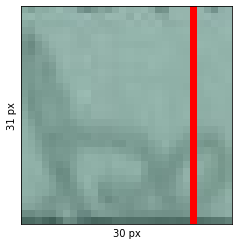

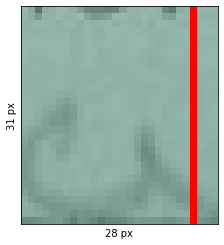

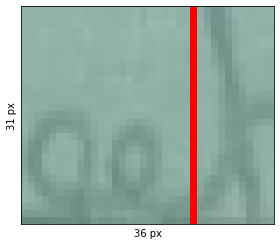

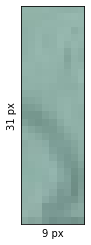

Field name: ALLOTMENT


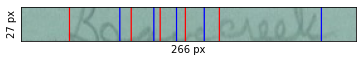

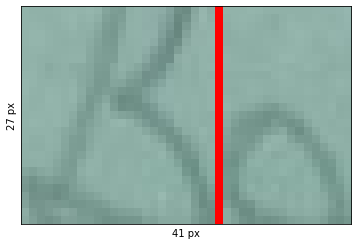

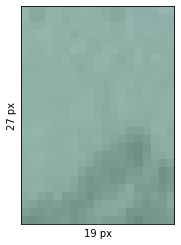

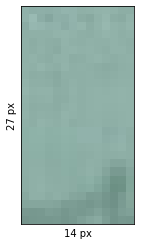

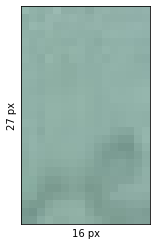

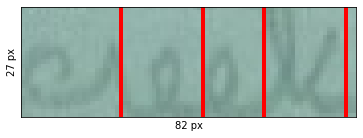

Field name: EXAMINER


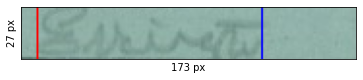

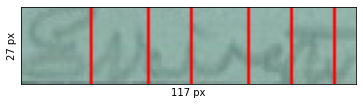

Field name: DATE


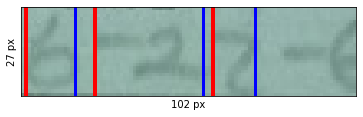

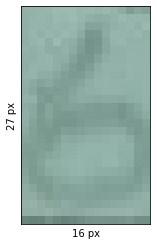

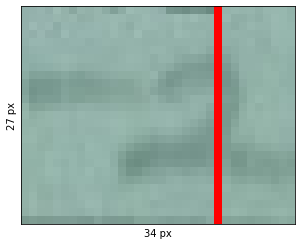

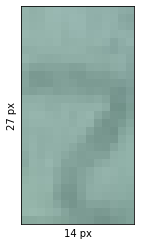

Field name: TRANSECT NO.


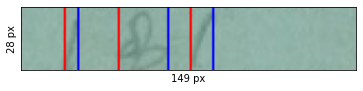

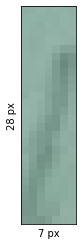

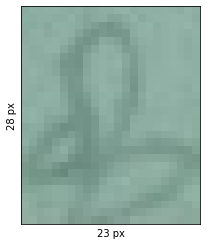

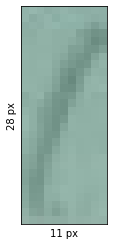

Field name: PLOT SIZE


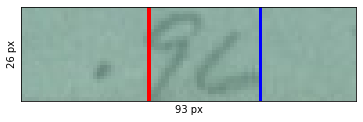

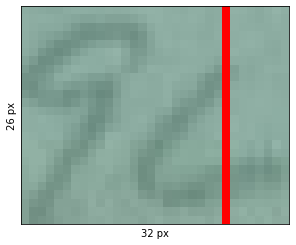

Field name: PLOT INTERVAL


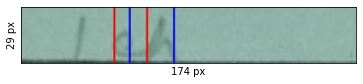

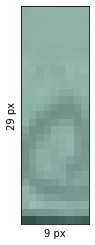

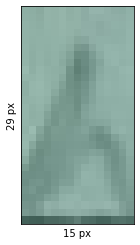

Field name: TYPE DESIGNATION


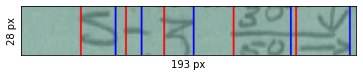

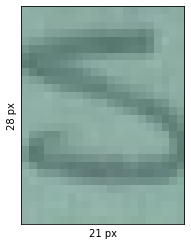

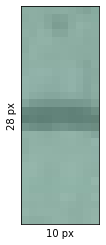

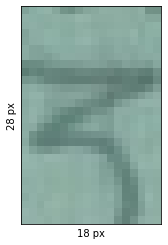

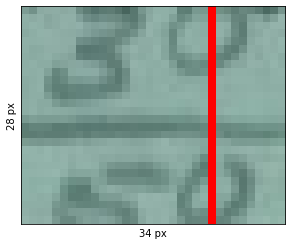

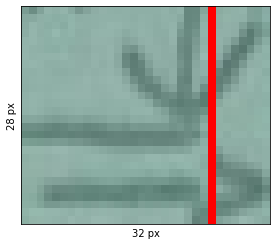

Field name: KIND OF LIVESTOCK


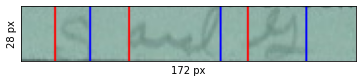

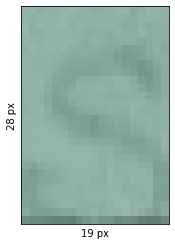

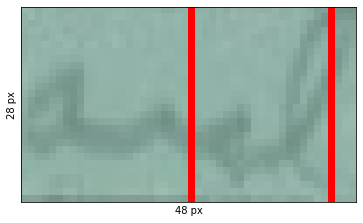

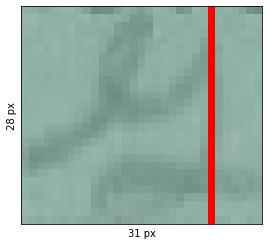

Field name: SLOPE


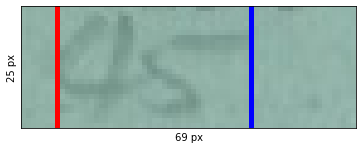

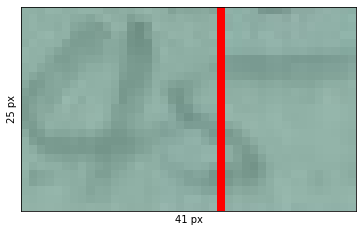

Field name: ASPECT


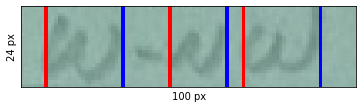

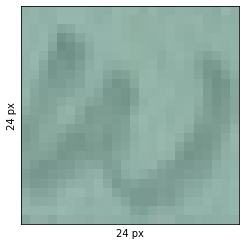

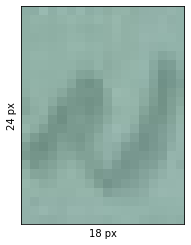

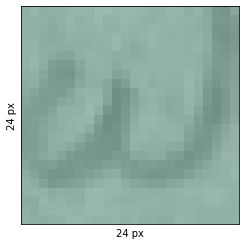

Field name: LOCATION


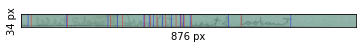

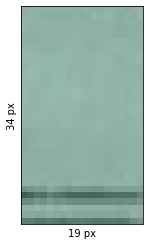

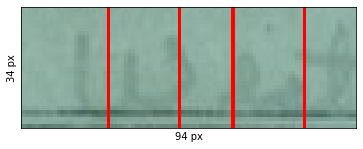

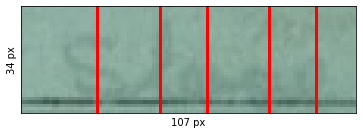

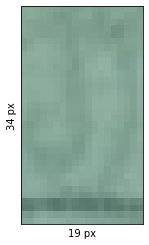

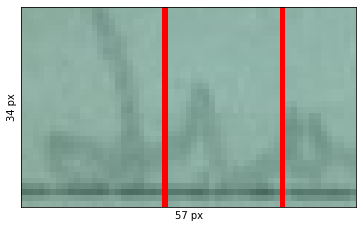

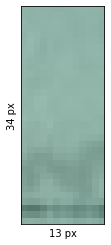

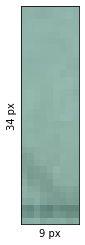

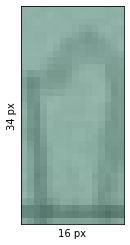

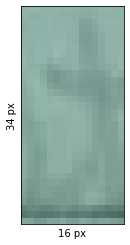

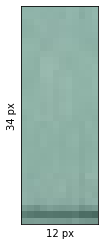

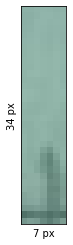

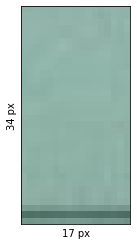

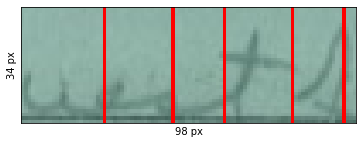

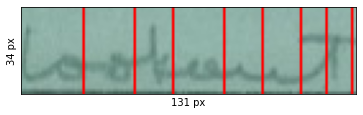

Field name: ELEVATION


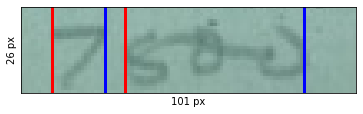

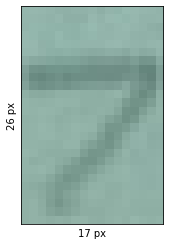

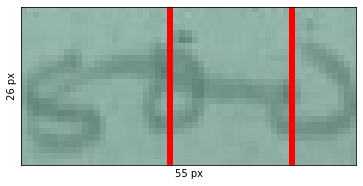

In [122]:
for field in fields:
    print(f"Field name: {field}")
    field = fields[field]
    # Get vertical projection
    gray_img = cv2.cvtColor(field, cv2.COLOR_BGR2GRAY)
    (thresh, thresh_img) = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    vertical_projection_hist = np.sum(thresh_img / 255, axis=0)
    # Segment it to words
    words = seg_field_words(vertical_projection_hist)
    segmented = field.copy()     
    for word in words:
        start, end = word
        segmented = cv2.line(segmented, (start, 0), (start, field.shape[0]), (0, 0, 255), 1)
        segmented = cv2.line(segmented, (end, 0), (end, field.shape[0]), (255, 0, 0), 1)
    show_image(segmented)
    # Segment words into characters
    for word in words:
        start, end = word
        word_v_hist_proj = vertical_projection_hist[start:end + 1]
        word_seg_p = segmentation_points(word_v_hist_proj, 3, 2, 5)

        seg = field.copy()[:, start:end+1]
        if word_seg_p:
            for seg_p in seg_points:
                seg = cv2.line(seg, (int(seg_p), 0), (int(seg_p), field.shape[0]), (0, 0, 255), 1)
        show_image(seg)
    

We can see that in some cases the slicing of characters is pretty good and we could take the length of those points to be our slicing window size.

Could results be improved if we first clean the image?

Field name: WRITEUP NO.


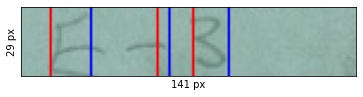

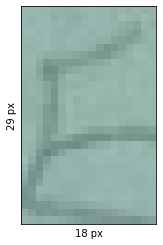

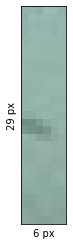

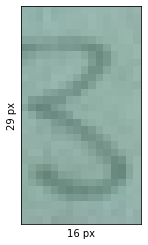

Field name: PHOTO NO.


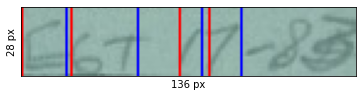

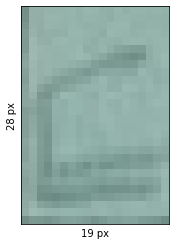

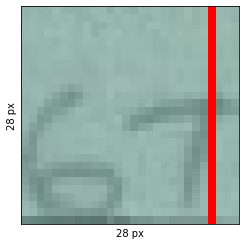

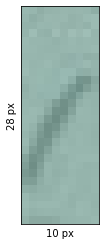

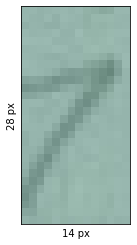

Field name: FOREST


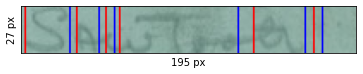

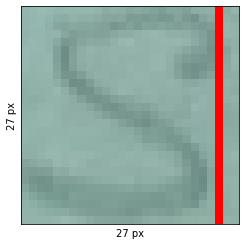

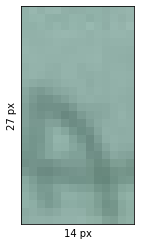

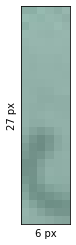

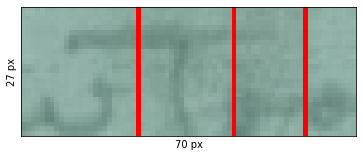

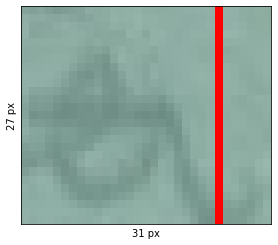

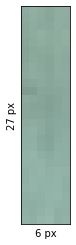

Field name: RANGER DISTRICT


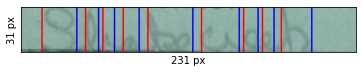

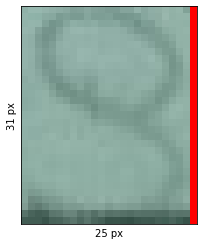

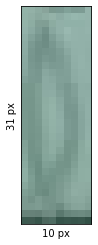

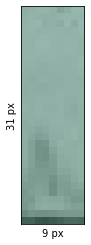

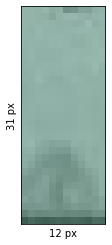

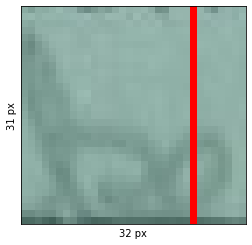

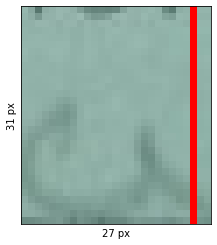

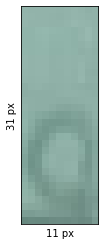

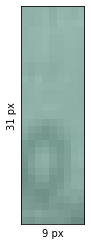

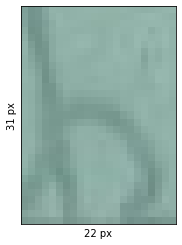

Field name: ALLOTMENT


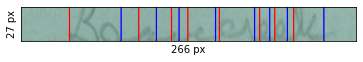

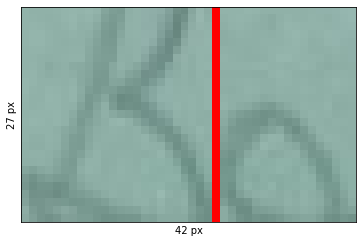

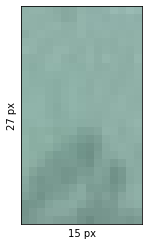

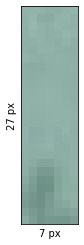

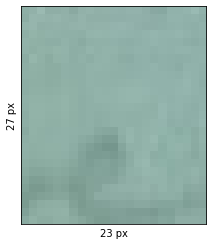

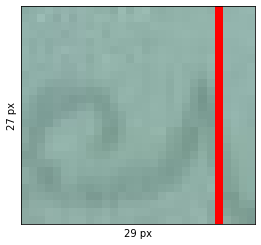

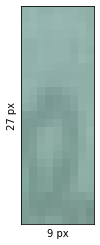

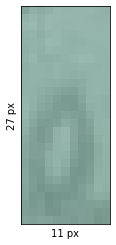

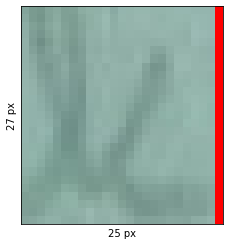

Field name: EXAMINER


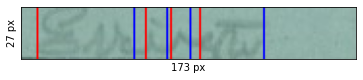

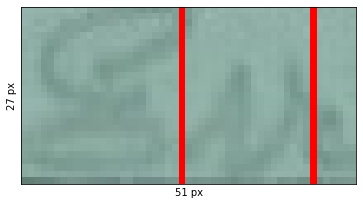

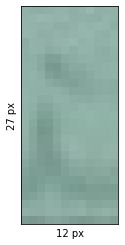

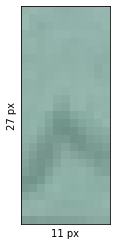

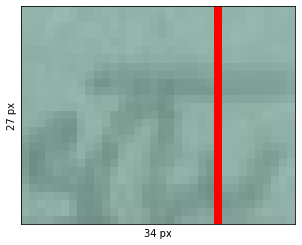

Field name: DATE


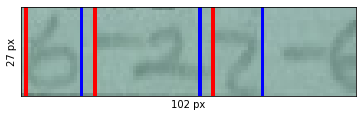

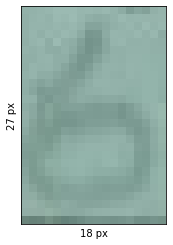

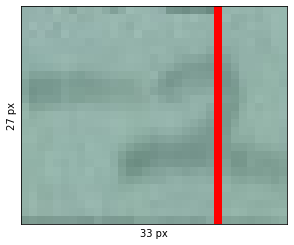

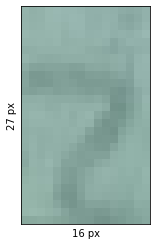

Field name: TRANSECT NO.


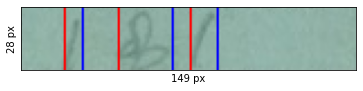

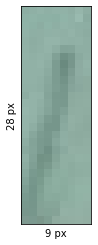

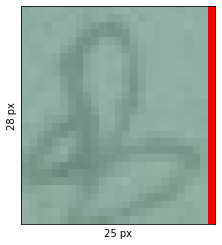

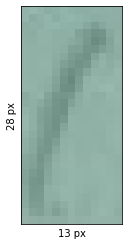

Field name: PLOT SIZE


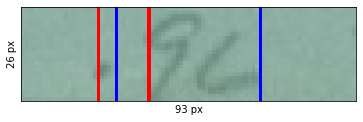

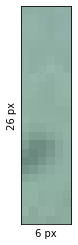

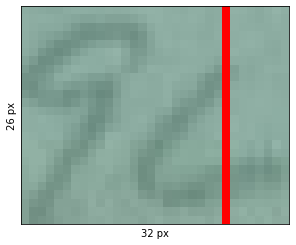

Field name: PLOT INTERVAL


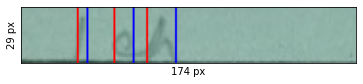

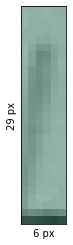

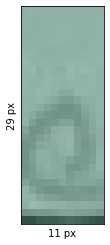

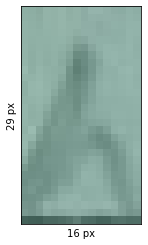

Field name: TYPE DESIGNATION


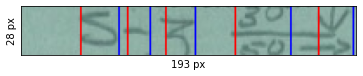

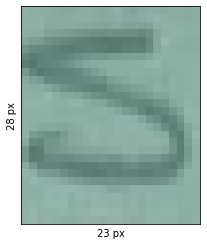

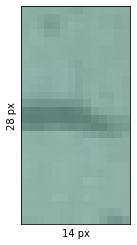

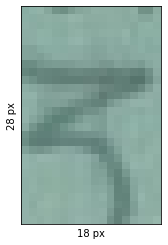

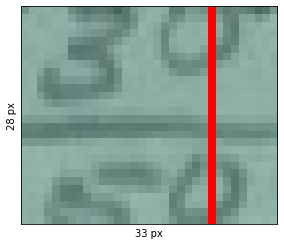

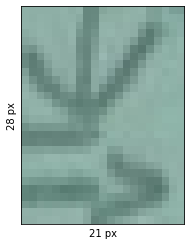

Field name: KIND OF LIVESTOCK


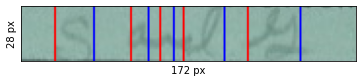

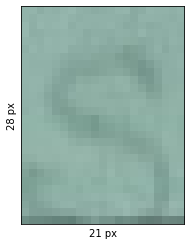

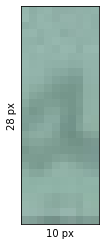

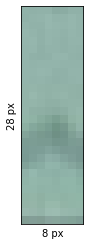

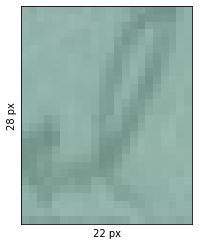

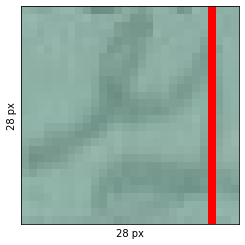

Field name: SLOPE


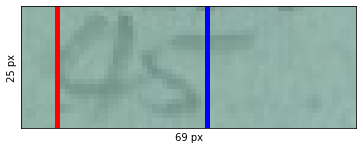

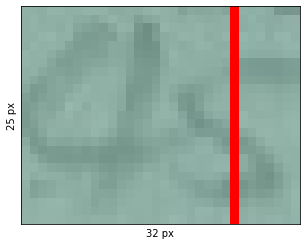

Field name: ASPECT


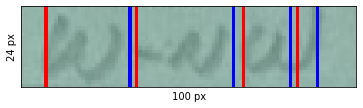

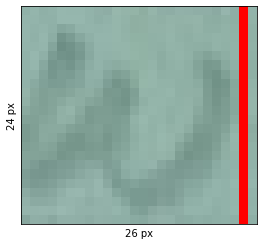

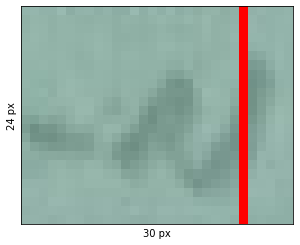

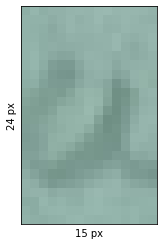

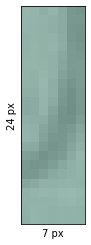

Field name: LOCATION


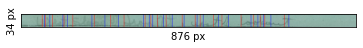

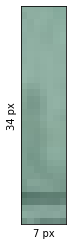

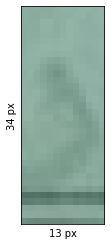

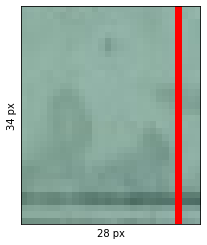

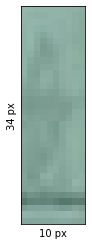

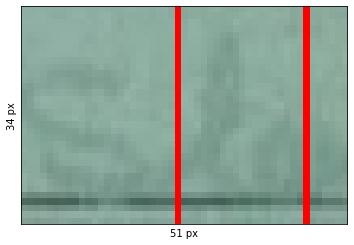

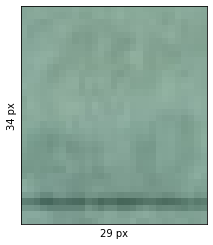

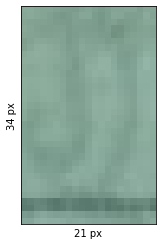

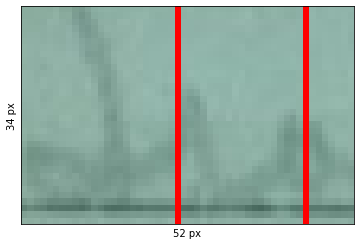

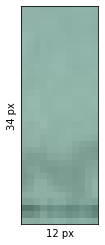

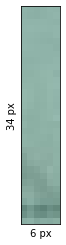

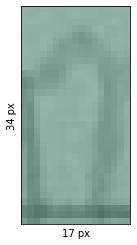

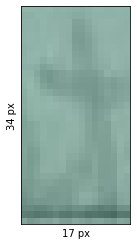

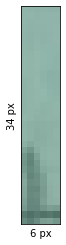

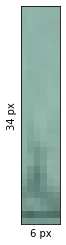

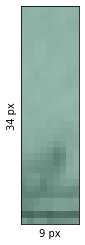

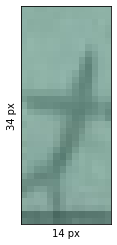

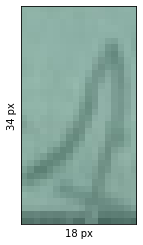

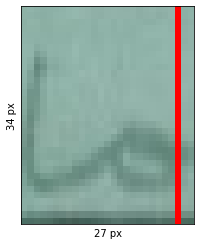

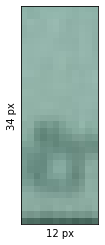

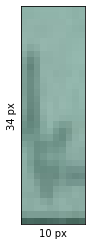

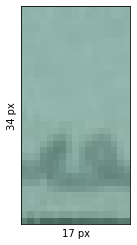

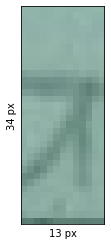

Field name: ELEVATION


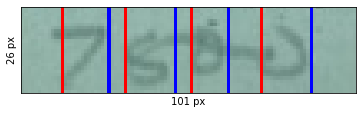

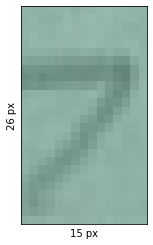

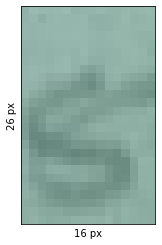

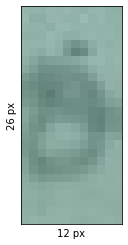

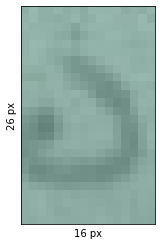

In [133]:
for field in fields:
    print(f"Field name: {field}")
    field = fields[field]
    # Threshold image
    gray_img = cv2.cvtColor(field, cv2.COLOR_BGR2GRAY)
    (thresh, thresh_img) = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    # Clean image
    thresh_img = remove_long_h_v_lines(thresh_img)
    # Horizontal dilation
    thresh_img = cv2.dilate(thresh_img, np.ones((1, 2), np.uint8), iterations=2)
    # Get vertical projection
    vertical_projection_hist = np.sum(thresh_img / 255, axis=0)
    # Segment it to words
    words = seg_field_words(vertical_projection_hist)
    segmented = field.copy()     
    for word in words:
        start, end = word
        segmented = cv2.line(segmented, (start, 0), (start, field.shape[0]), (0, 0, 255), 1)
        segmented = cv2.line(segmented, (end, 0), (end, field.shape[0]), (255, 0, 0), 1)
    show_image(segmented)
    # Segment words into characters
    for word in words:
        start, end = word
        word_v_hist_proj = vertical_projection_hist[start:end + 1]
        word_seg_p = segmentation_points(word_v_hist_proj, 3, 2, 5)

        seg = field.copy()[:, start:end+1]
        if word_seg_p:
            for seg_p in seg_points:
                seg = cv2.line(seg, (int(seg_p), 0), (int(seg_p), field.shape[0]), (0, 0, 255), 1)
        show_image(seg)
    

We see that in many cases it slices the characters correctly during the word slicing process (before the character slicing process)

It does a good job on most of the cases. I think this results are better so we can conclude that applying it on a cleaned image improves performance.